- We also show this test-time noise manipulation can be easily extensible to other types of conditioning, e.g., edge maps.

- We conduct extensive experiments using a variety of text prompts, color palettes, and edge maps and demonstrate significant improvement over the current state-of-the-art, both qualitatively and quantitatively.

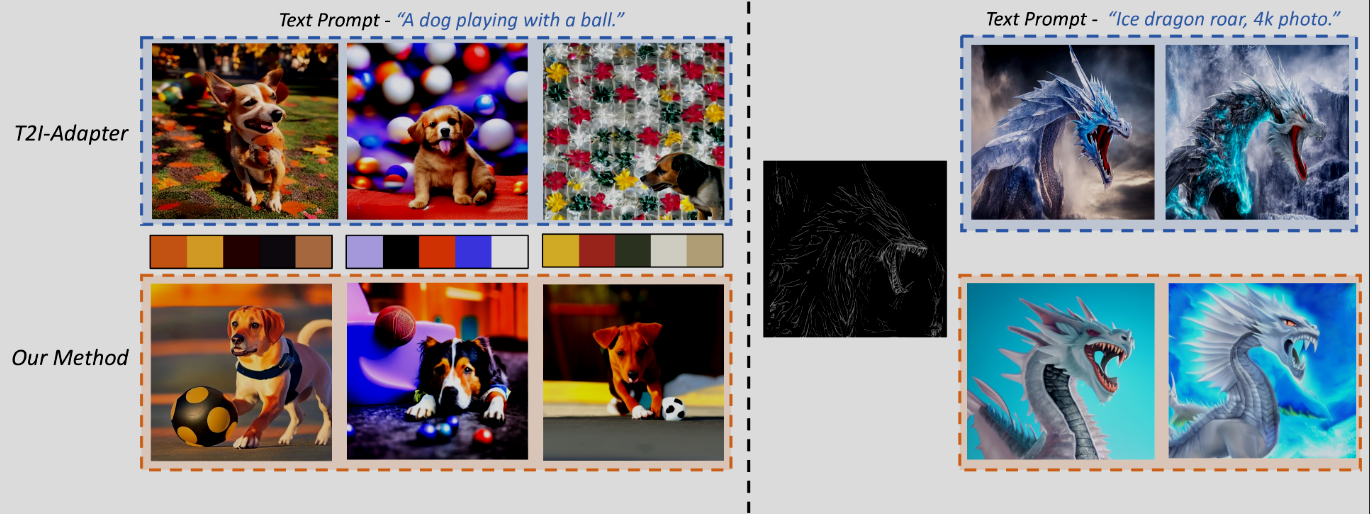

- For instance, methods like ControlNet (Liu et al. 2023) presented ways to condition the outputs of text-to-image diffusion models on a wide variety of conditioning factors such as color, edge, depth, etc. Since then, many other methods have been proposed.

- With the dramatic rise in the capabilities of text-to-image diffusion models (Rombach et al. 2022; Saharia et al. 2022) in generating creative imagery from text prompts, much recent effort has been expended in controlling the outputs generated by these models. For instance, methods like ControlNet (Liu et al. 2023) presented ways to condition the outputs of text-to-image diffusion models on a wide variety of conditioning factors such as color, edge, depth, etc. Since then, many other methods have been proposed (Mou et al. 2023) that seek to train additional modules to incorporate the extra conditioning input along with the text prompt. A recent contribution in the realm of training-free approaches is presented in the work by Yu et al. (referred as FreeDoM from here onwards)(Yu et al. 2023). This approach empowers conditional generation without the need for training or fine-tuning additional models. It excels in handling relatively simple conditions such as poses, segmentation maps, and similar factors.

## Proposed solution
- we propose methods to manipulate the intermediate representations produced by the diffusion model during the denoising process at test time.

- We propose new loss functions for the specific tasks that help guide the intermediate noise predictions towards the desired state which when decoded give us the expected conditioned model outputs.


We present two specific instantiations of our approach :
 - with color conditioning in the form of color palettes.
 - edge conditioning in the form of edge maps.
 - Comparing with FreeDoM (Yu et al. 2023), we propose a novel color loss function that promotes alignment between the target color distribution and the generated image’s color distribution.
 - We also propose a iterative sampling strategy specific to color and edge conditioning during test-time image generation.

## To summarize, the key contributions of this paper include:

- We present a test-time-only approach to condition diffusion model outputs with external conditioning factors like color palettes and edge maps by interpreting noise predictions as the gradients of an energy-based model.
- To the best of our knowledge, we present the first approach to condition diffusion models with color palettes without any retraining and only using a test-time manipulation of the noise predictions by matching the color distributions of the input palette and the prediction at a particular denoising step.
- We introduce a novel loss function L<sub>DS</sub> to optimize the alignment between the generated color distribution and the target palette distribution, enhancing the fidelity of the synthesized images.
- We present an iterative sampling strategy optimized for color and edge conditioning for test-time conditional generation.

## Why other Text-to-image synthesis models are preferred over conditional GAN's?

- Generative Adversarial Networks (GANs) suffer from training instability and poor generalizability.
- A recent trend in the diffusion model domain focuses on conditional image generation.
- Some approaches address text guidance by manipulating prompts or modifying cross-attention.
- Other methods, such as T2I-Adapter (Mou et al. 2023), Control-Net (Liu et al. 2023), and UniControlNet (Zhao et al. 2023), introduce additional conditions like pose, color, or segmentation maps to guide image generation alongside text prompts.
- However, these methods commonly rely on training or fine-tuning additional models, limiting their generalizability and usability across diverse conditions, and incurring associated training costs that impede broad applicability.


## Why Training Free models are proposed?

- To address these challenges, some training-free approaches for conditional generation have been proposed.

- These methods eliminate the need for training or fine-tuning additional models, offering a more versatile and accessible solution.

- However, existing training-free approaches exhibit limitations when dealing with more nuanced conditions, such as color palettes and edge maps.

- Moreover, their performance struggles in large-data domains, and their generalizability is often confined to specific conditions like human faces.

- As discussed in 1, existing methods like (Mou et al. 2023; Liu et al. 2023) train models for conditional image generation. Recent works such as (Yu et al. 2023) offer conditioning during inference, avoiding the need to train separate models. However, these methods only handle simple conditions like pose, style, and text, and struggle with large datasets like Imagenet.

## Why color pallete? 
- For precise control over image generation, especially for detailed conditions like color and layout during test-time, conditional generation models are essential.

- Song et al.(Song et al. 2021) introduced a score-based model using Stochastic Differential Equation (SDE) for conditional generation.

- Their conditional reverse-time SDE, estimated from unconditional scores, significantly improves conditional synthesis.

- This inspires our exploration of score-based models for optimizing conditional generation.

## Preliminaries

Latent Diffusion Model. Diffusion models (Sohl-Dickstein et al. 2015; Ho, Jain, and Abbeel 2020) are probabilistic models for generating samples from a target data distribution. The generative process starts with a sample 
x
0
∼
p
⁢
(
x
0
)
 and gradually denoises it over 
T
 iterations. This process transforms a normally distributed random variable 
x
T
∼
𝒩
⁢
(
0
,
I
)
 into a series of intermediate samples 
x
T
,
x
T
−
1
,
…
,
x
0
, each with less noise. A neural network 
ϵ
θ
⁢
(
x
t
,
t
)
 determines the noise reduction at each step.

Conditional Score Function. We overview score-based diffusion models (SBDMs) and conditional generation using them. SBDMs (Song and Ermon 2020; Song et al. 2022) are a type of diffusion model based on score theory. They estimate the score function 
∇
x
t
log
⁡
p
⁢
(
x
t
)
 using a score estimator 
s
⁢
(
x
t
,
t
)
, where 
x
t
 is noisy data and 
t
 is the time-step. The score function provides the gradient of the log-likelihood of the data. During sampling, SBDMs derive 
x
t
−
1
 from 
x
t
 using this score function.

As discussed in Section 3, score-based models enable conditional generation since the conditional reverse-time SDE (Song et al. 2022) can be estimated from unconditional scores. The score function can be modified as 
∇
x
t
log
⁡
p
⁢
(
x
t
|
c
)
, incorporating a given condition 
c
. Using Bayes’ theorem (Bayes 1763), the conditional score function can be written as:

∇
𝐱
t
log
⁡
p
⁢
(
𝐱
t
|
𝐜
)
=
∇
𝐱
t
log
⁡
p
⁢
(
𝐱
t
)
+
∇
𝐱
t
log
⁡
p
⁢
(
𝐜
|
𝐱
t
)
(1)
where 
∇
x
t
log
⁡
p
⁢
(
x
t
)
 is estimated from a pre-trained unconditional score estimator 
𝐬
⁢
(
𝐱
𝐭
,
𝐭
)
 and 
∇
x
t
log
⁡
p
⁢
(
c
|
x
t
)
 enforces the condition in the model. The second term 
∇
x
t
log
⁡
p
⁢
(
c
|
x
t
)
 serves as a correction gradient, steering 
x
t
 towards data that matches the condition 
c
. Time-dependent classifiers (Liu et al. 2023; Zhao et al. 2022; Nichol et al. 2021; Dhariwal and Nichol 2021) are trained to compute this correction gradient for precise conditional guidance.

Energy Guided Diffusion. We model the correction gradient 
∇
x
t
log
⁡
p
⁢
(
c
|
x
t
)
 as an energy function:

p
⁢
(
𝐜
|
𝐱
t
)
=
exp
⁡
{
−
λ
⁢
ℰ
⁢
(
𝐜
,
𝐱
t
)
}
∫
𝐜
∈
𝐂
exp
⁡
{
−
λ
⁢
ℰ
⁢
(
𝐜
,
𝐱
t
)
}
(2)
where 
𝐜
 is the condition, and 
λ
 is the positive temperature coefficient. The energy function 
−
E
⁢
(
c
,
𝐱
t
)
 measures the alignment between 
𝐜
 and 
𝐱
𝐭
, producing smaller values when they align better. Thus, the correction gradient is:

∇
𝐱
t
log
⁡
p
⁢
(
𝐜
|
𝐱
t
)
∝
−
∇
𝐱
t
ℰ
⁢
(
𝐜
,
𝐱
t
)
,
(3)
called energy conditioning. Using the standard DDPM equation (Ho, Jain, and Abbeel 2020), Eq. 1, and Eq. 3, the conditional sampling formula is:

𝐱
t
−
1
=
𝐫
t
−
α
t
⁢
∇
𝐱
t
ℰ
⁢
(
𝐜
,
𝐱
t
)
,
(4)
where 
𝐫
𝐭
 is the standard DDPM sampling formula and 
α
𝐭
 is the learning rate of energy conditioning.

Time Independent Energy Approximation. Some methods (Yu et al. 2023) approximate energy conditioning using time-independent distance functions due to many pretrained functions for clean data 
𝐱
𝟎
:

𝒟
ϕ
⁢
(
𝐜
,
𝐱
t
,
t
)
≈
𝔼
p
⁢
(
𝐱
0
|
𝐱
t
)
⁢
[
𝒟
𝜽
⁢
(
𝐜
,
𝐱
0
)
]
.
(5)
where 
𝒟
ϕ
⁢
(
𝐜
,
𝐱
t
,
𝐭
)
 approximates energy conditioning with pretrained parameter 
ϕ
. 
𝒟
𝜽
⁢
(
𝐜
,
𝐱
0
)
 denotes time-independent distance networks for clean data with pretrained parameter 
θ
. The distance between 
𝐱
𝐭
 and 
𝐜
 is proportional to the distance between 
𝐱
𝟎
 (corresponding to 
𝐱
𝐭
) and 
𝐜
, especially in the final sampling stages.

The time-dependent energy conditioning is approximated as:

ℰ
⁢
(
𝐜
,
𝐱
t
)
≈
𝒟
𝜽
⁢
(
𝐜
,
𝐱
0
|
t
)
.
(6)
Combining Eq. 4 and Eq. 6, the sampling equation is:

𝐱
t
−
1
=
𝐫
t
−
α
t
⁢
∇
𝐱
t
𝒟
𝜽
⁢
(
𝐜
,
𝐱
0
|
t
⁢<sub>
(
𝐱
t
)
⁢</sub>)
,


## Self attention
- Objectives of self attention is to understand what is relevant to an entity out of everything in its context.

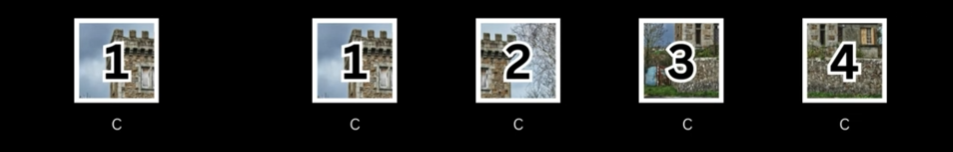
<br>

- assume we divide an image into 4 2*2 feature maps i,ii,iii,iV

- Add more meaning to the representation of an entity by using the representation of its context.

- Assume 3 matrices Wq, Wk, Wv each of those matrix is (C*attention_dim) 
    - Q (Query): Input representation. We are trying to quantify how much is every context item relevant to this representation.That is i.
    - K (Key): Context representation. Used to quantify relevance to the query representation. Here that is i,ii,iii,iv
    - V (Value): Context representation which is used to add understanding of relevant context into input/query

- Once we have query representation for i and K representation for i,ii,iii and iv the relevance for each context item to the input is computed by using scaled dot product
<br>

    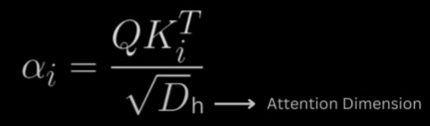
<br>

- Then relevance is computed using key representations that is a1,a2,a3,a4 and use softmax of relevance values.

<br>

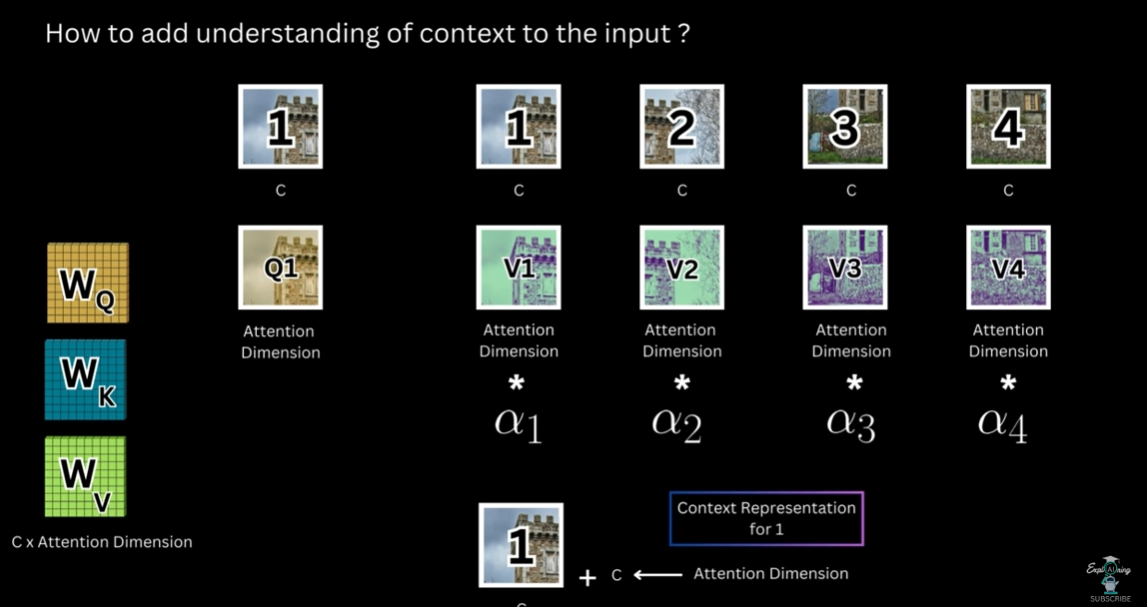

<br>
- And finally with value representations computed using Wv mat we get context representation with Summing up PRODUCT OF VALUES AND SCALED DOT PRODUCT.

- Then project value representations to channel dimesnion and simply ad this to representation of i.

## Cross Attention
- In Self-Attention:
    - Query: Spatial Image Features
    - Key: Spatial Image Features
    - Values: Spatial Image Features
- In Cross-Attention:
    - Query: Spatial Image Features
    - Key: Sequence of Context Features
    - Values: Sequence of Context Features

- To get representation of text sentence is to pass the words of sentence to tokenizer, and the tokenizer tokenizes them based on th grammar and send them to a text encoder. The output of encoder is (BATCH SIZE * SEQUENCE LENGTH * EMBEDDING DIMENSION)
    - For example: BERT encoder etc.

- Identifying what text token is relevant to an entity out of all tokens
- Add more meaning to the representation of an entity by using the representation of relevant tokens

<br>

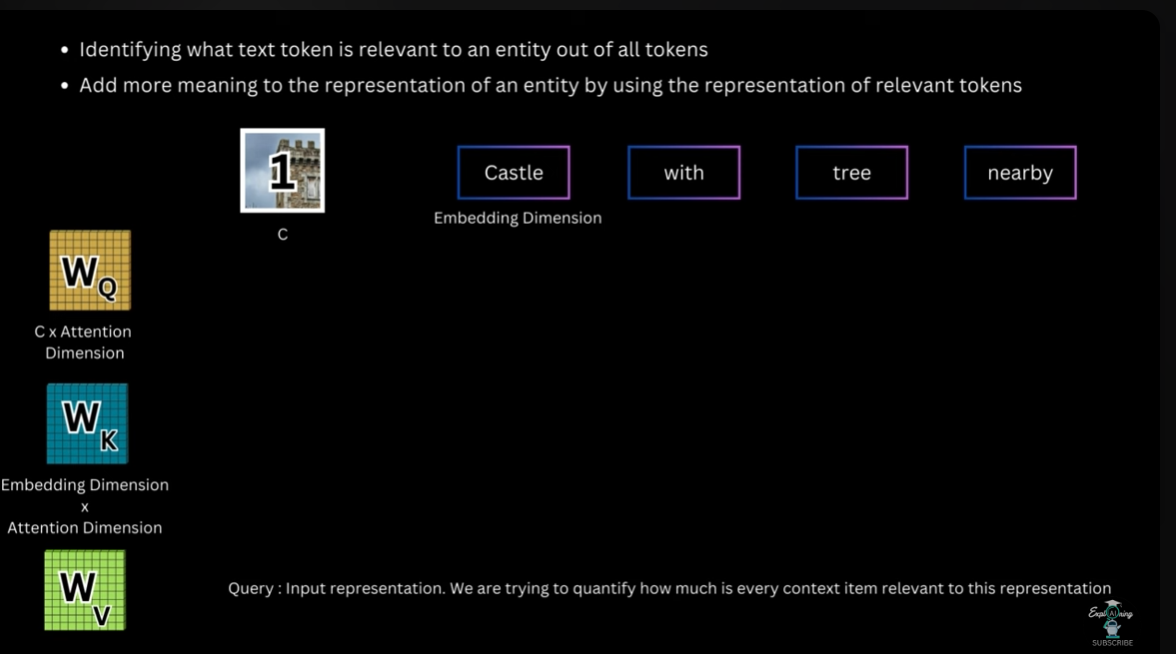
<br>

- Query: Input representation, We are trying to quantify how much is every context item relevant to this representation.
- Key: Context representation. Used to quantify relevance of token to the query representation
- Value: Context representation, which will be used to add understanding of relevant token into the input/query



We stack ResNet-> Self Attention Block -> Cross Attention Block
with same normalization and residual connection.

<br>

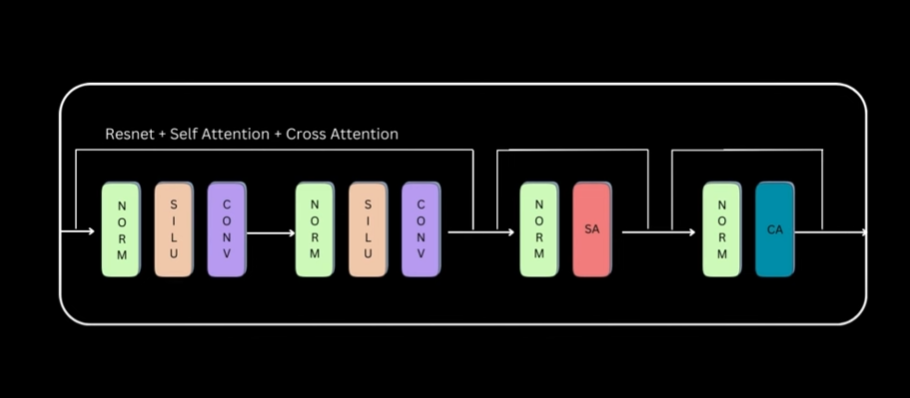

## Image conditioning Using Cross Attention

Get representation of image using ViT. and we can use cross representation here as well

- Query will stil be spatial feature map representation of noise

<br>

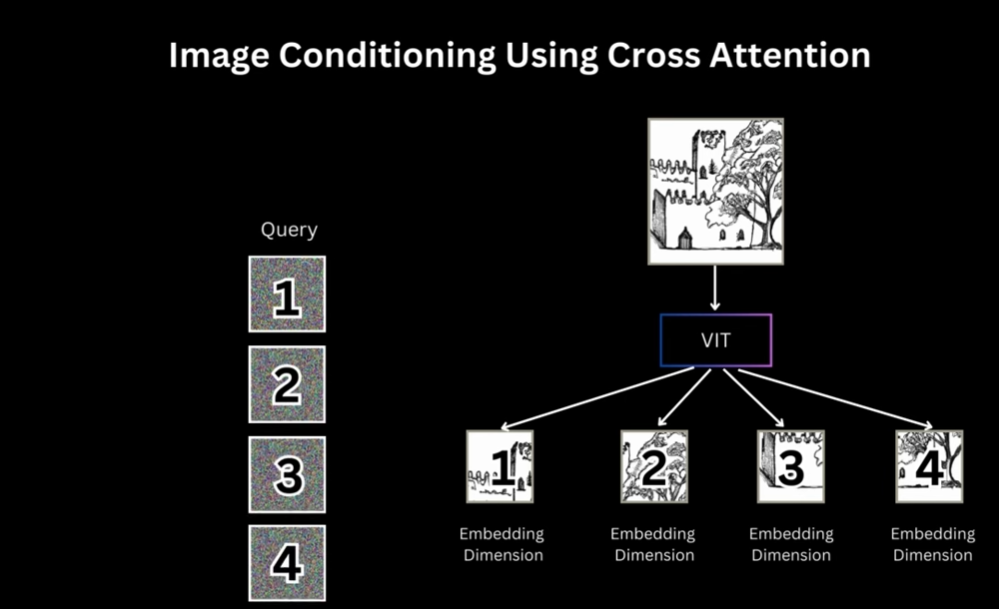

In [ ]:
## 

In [1]:
import torch
import json

In [2]:
data = None
with open('./coco/annotations/captions_train2014.json','r+') as stream:
    data = json.load(stream)

In [3]:
cap = (data['annotations'])
len(cap)

414113

In [ ]:
int('000000318556')

318556

In [5]:
from torch.utils.data import Dataset


class CocoWithAnnotations(Dataset):
    # def 
    pass

In [6]:
from utils.text import sentence_embs

cap_emb = sentence_embs(cap[0]['caption'])

A
clean
decorated
empty
bathroom


In [7]:
cap_emb

[283, 201, 122, 9, 8]

In [2]:
from transformers import CLIPTokenizer

# Load the tokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Example usage
text = "a photo of a cat"
tokens = tokenizer(text, padding=True, truncation=True, max_length=77, return_tensors="pt")

# tokens will contain 'input_ids' and 'attention_mask'
print(tokens)

C:\Users\vishw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vishw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vishw\.cache\huggingface\hub\models--openai--clip-vit-large-patch14. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/hu

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


torch.Tensor

the conditional score function can be written as:<br>
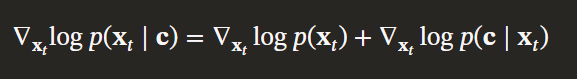(1)
<br>

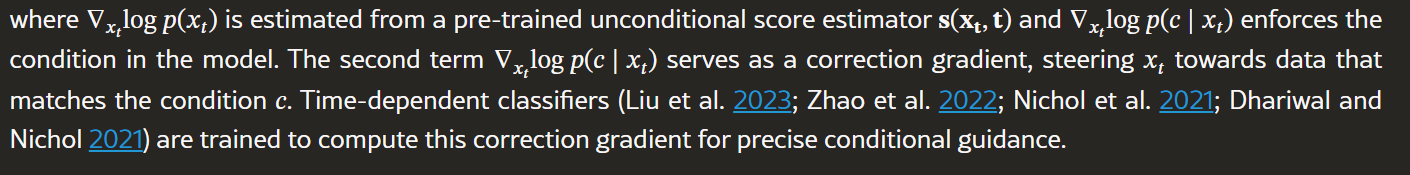

<br>
